### Gathering the data from the tables stored on snowflake

In [ ]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
from pathlib import Path
env_path = Path('.') / 'environment.env'
load_dotenv(dotenv_path=env_path)

SF_USER = os.getenv("SF_USER")
SF_PASSWORD = os.getenv("SF_PASSWORD")
SF_ACCOUNT = os.getenv("SF_ACCOUNT")
SF_WAREHOUSE = os.getenv("SF_WAREHOUSE")
SF_DATABASE = os.getenv("SF_DATABASE")
SF_SCHEMA = os.getenv("SF_SCHEMA")

# Conexão com Snowflake
conn = snowflake.connector.connect(
    user=SF_USER,
    password=SF_PASSWORD,
    account=SF_ACCOUNT,
    warehouse=SF_WAREHOUSE,
    database=SF_DATABASE,
    schema=SF_SCHEMA
)

# ============================
# Consultas
# ============================
df_customers = pd.read_sql("SELECT * FROM customers_refined", conn)
df_orders = pd.read_sql("SELECT * FROM orders_refined", conn)
df_payments = pd.read_sql("SELECT * FROM order_payments_refined", conn)

# Fecha conexão
conn.close()

# ============================
# Padroniza nomes de colunas
# ============================
for df in [df_customers, df_orders, df_payments]:
    df.columns = df.columns.str.lower()

# ============================
# Função para converter timestamp
# ============================
def safe_timestamp_to_datetime(series):
    series = pd.to_numeric(series, errors='coerce')
    if series.dropna().empty:
        return pd.NaT
    max_val = series.max()
    if max_val > 1e18:           # nanosegundos
        unit = 'ns'
    elif max_val > 1e12:         # milissegundos
        unit = 'ms'
    else:                        # segundos
        unit = 's'
    return pd.to_datetime(series, unit=unit, errors='coerce')

# Converte timestamps em orders
if 'order_purchase_timestamp' in df_orders.columns:
    df_orders['order_purchase_datetime'] = safe_timestamp_to_datetime(df_orders['order_purchase_timestamp'])

# ============================
# Merge Orders + Customers
# ============================
df_orders_customers = df_orders.merge(
    df_customers[['customer_id', 'customer_city', 'customer_state', 'customer_zip_code_prefix']],
    on='customer_id',
    how='left'
)

print("Orders + Customers:")
print(df_orders_customers.head())
print(f"Total registros: {len(df_orders_customers)}")


SF_USER: DAVISIQUEIRA
SF_ACCOUNT: PAILQHF-SD40239
SF_PASSWORD: TrFHv.bEB.u8Seg


C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\1952120570.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql("SELECT * FROM customers_refined", conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\1952120570.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders = pd.read_sql("SELECT * FROM orders_refined", conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\1952120570.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_payments = pd.read_sql("SELECT * FROM order_payments_r

Orders + Customers:
                           order_id                       customer_id  \
0  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
1  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
2  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  85ce859fd6dc634de8d2f1e290444043  059f7fc5719c7da6cbafe370971a8d70   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      1511033286000000000  1511034359000000000   
1    delivered      1511033286000000000  1511034359000000000   
2    delivered      1511033286000000000  1511034359000000000   
3    delivered      1511033286000000000  1511034359000000000   
4    delivered      1511222621000000000  1511223262000000000   

  order_delivered_carrier_date order_delivered_customer_date  \
0          1511357999000000000           1512174522000000000   
1          15113579990000000

### Analise bivariada de Orders x Customers x Order_payment


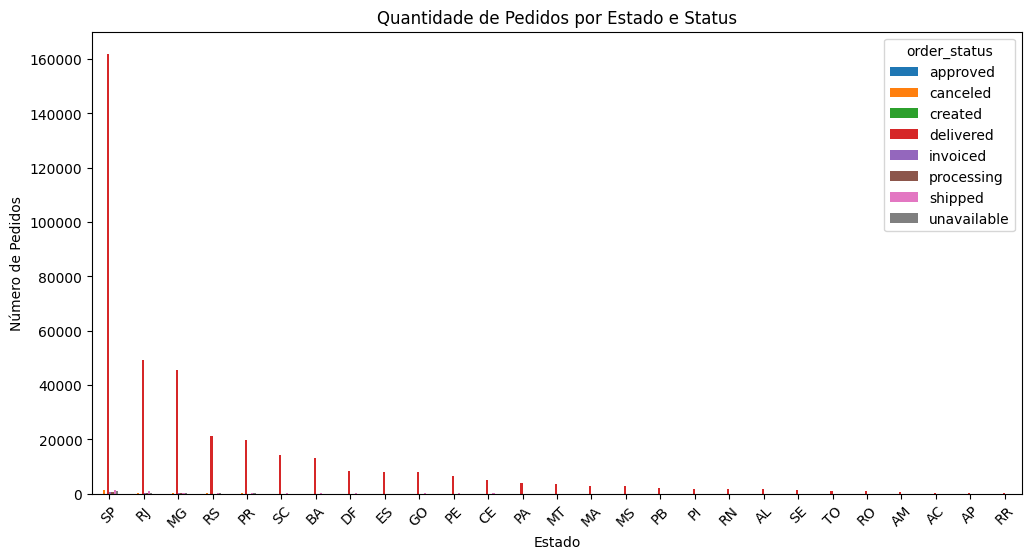

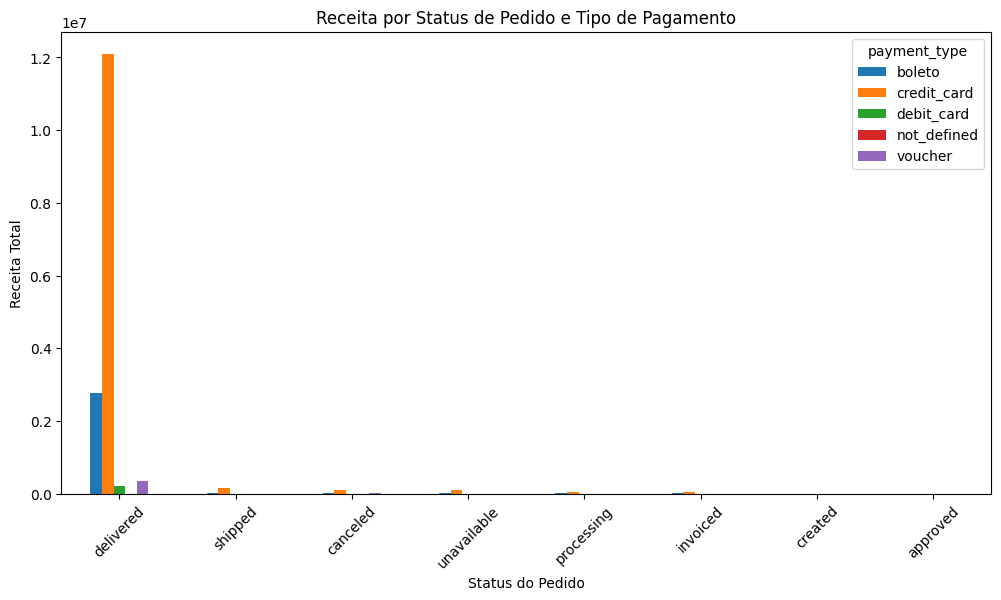

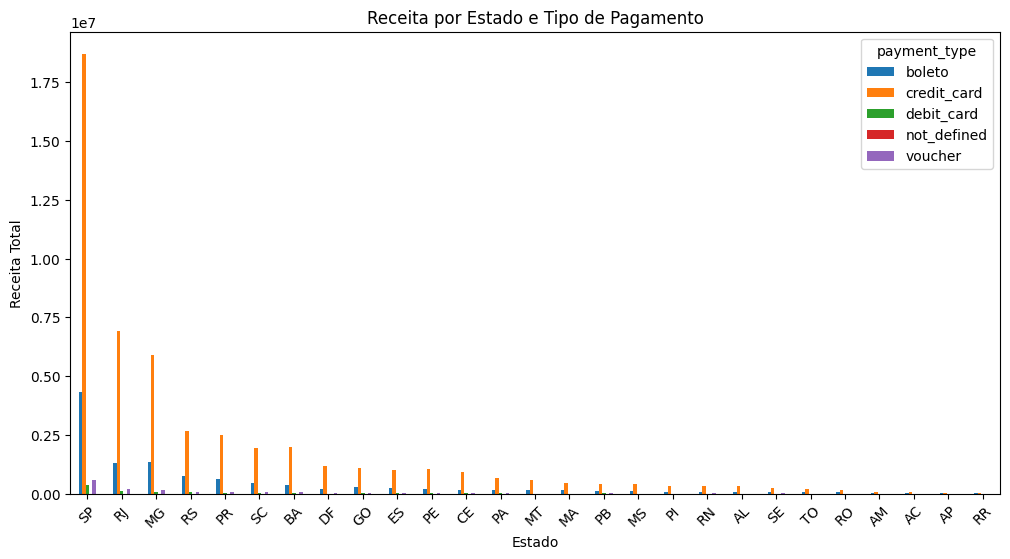

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Função para plotar gráfico simples (uma barra por categoria)
def plot_simple_bar(pivot_df, title, xlabel, ylabel):
    pivot_df.plot(kind='bar', figsize=(12,6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title=pivot_df.columns.name)
    plt.show()

# --- 1. Customers × Orders (quantidade de pedidos por estado e status) ---
cust_orders_counts = df_orders_customers.groupby(['customer_state', 'order_status']).size().reset_index(name='count')
pivot_cust_orders = cust_orders_counts.pivot(index='customer_state', columns='order_status', values='count').fillna(0)
pivot_cust_orders = pivot_cust_orders.loc[pivot_cust_orders.sum(axis=1).sort_values(ascending=False).index]
plot_simple_bar(pivot_cust_orders, 'Quantidade de Pedidos por Estado e Status', 'Estado', 'Número de Pedidos')

# --- 2. Orders × Order Payments (receita por status do pedido e tipo de pagamento) ---
df_orders_payments = df_orders.merge(df_payments, on='order_id', how='left')
df_orders_payments['payment_value'] = pd.to_numeric(df_orders_payments['payment_value'], errors='coerce').fillna(0)

orders_payments_rev = df_orders_payments.groupby(['order_status', 'payment_type'])['payment_value'].sum().reset_index()
pivot_orders_payments = orders_payments_rev.pivot(index='order_status', columns='payment_type', values='payment_value').fillna(0)
pivot_orders_payments = pivot_orders_payments.loc[pivot_orders_payments.sum(axis=1).sort_values(ascending=False).index]
plot_simple_bar(pivot_orders_payments, 'Receita por Status de Pedido e Tipo de Pagamento', 'Status do Pedido', 'Receita Total')

# --- 3. Customers × Order Payments (receita por estado e tipo de pagamento) ---
df_cust_payments = df_orders_payments.merge(df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')
cust_payments_rev = df_cust_payments.groupby(['customer_state', 'payment_type'])['payment_value'].sum().reset_index()
pivot_cust_payments = cust_payments_rev.pivot(index='customer_state', columns='payment_type', values='payment_value').fillna(0)
pivot_cust_payments = pivot_cust_payments.apply(pd.to_numeric, errors='coerce').fillna(0)
pivot_cust_payments = pivot_cust_payments.loc[pivot_cust_payments.sum(axis=1).sort_values(ascending=False).index]
plot_simple_bar(pivot_cust_payments, 'Receita por Estado e Tipo de Pagamento', 'Estado', 'Receita Total')


### Analise univariada de customers_refined

Variáveis numéricas: []
Variáveis categóricas: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'customer_city_clean']


C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\1604906087.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_zips.values, y=top_zips.index, palette="coolwarm")


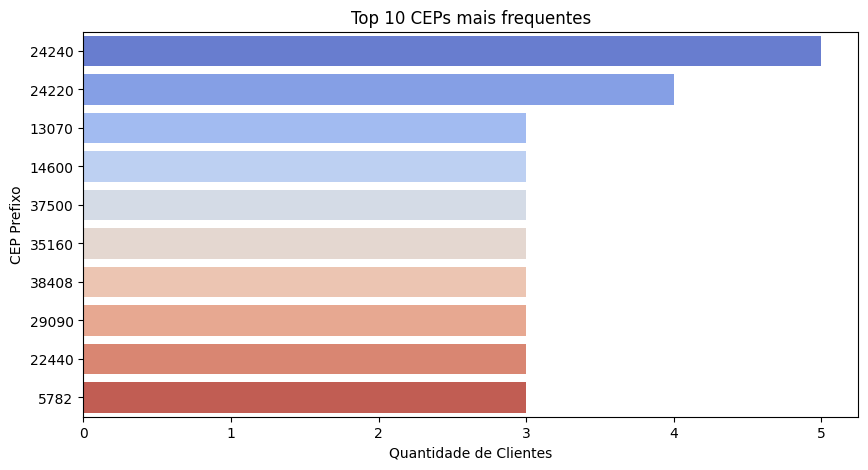

C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\1604906087.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")


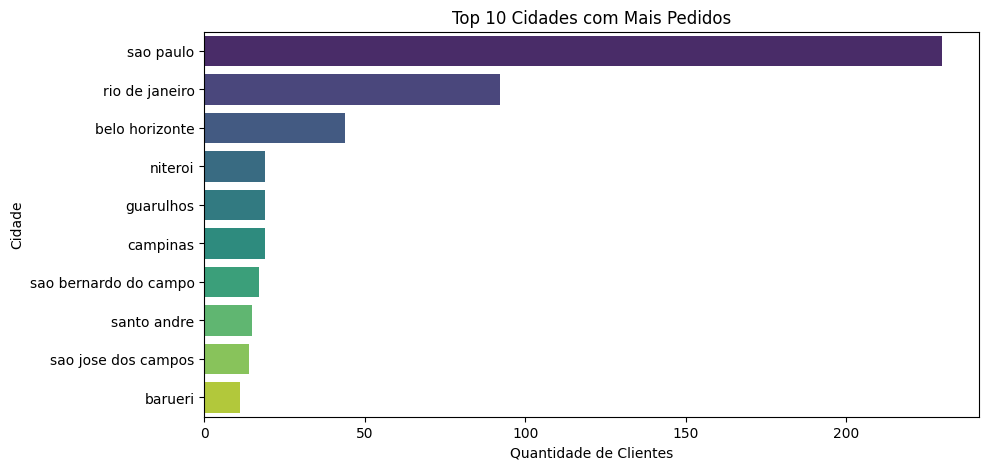

C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\1604906087.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette="magma")


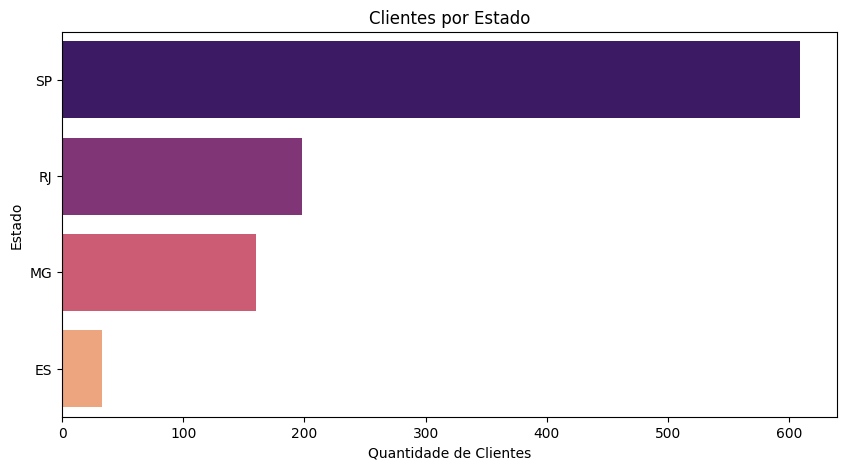


📊 Proporção de clientes por estado:
Estado  Clientes Percentual (%)
    SP       609          60.90
    RJ       198          19.80
    MG       160          16.00
    ES        33           3.30


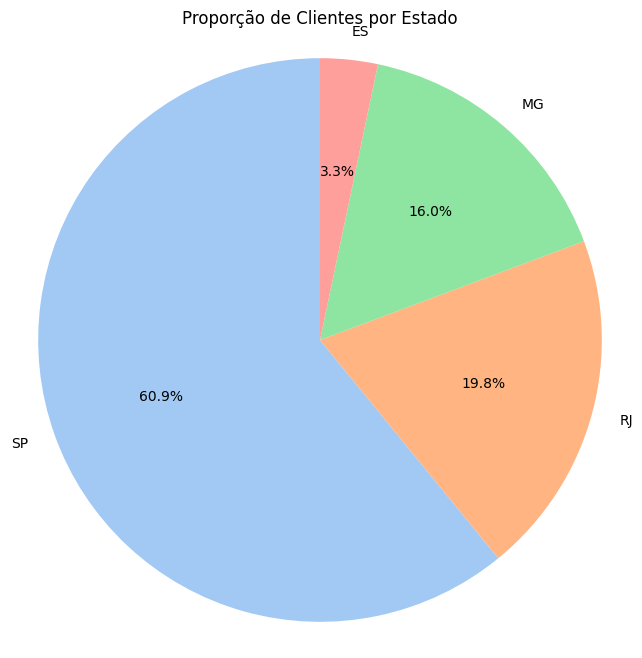

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Separar variáveis numéricas e categóricas
# ============================
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Se o zip code estiver como numérico, tratamos como string
if 'customer_zip_code_prefix' in num_cols:
    df['customer_zip_code_prefix'] = df['customer_zip_code_prefix'].astype(str)
    num_cols.remove('customer_zip_code_prefix')
    cat_cols.append('customer_zip_code_prefix')

print("Variáveis numéricas:", num_cols)
print("Variáveis categóricas:", cat_cols)

# ============================
# 1. Análise univariada - Zip Code Prefix (agora categórico)
# ============================
if 'customer_zip_code_prefix' in cat_cols:
    top_zips = df['customer_zip_code_prefix'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_zips.values, y=top_zips.index, palette="coolwarm")
    plt.title("Top 10 CEPs mais frequentes")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("CEP Prefixo")
    plt.show()

# ============================
# 2. Análise univariada - Cidades
# ============================
if 'customer_city' in cat_cols:
    top_cities = df['customer_city'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")
    plt.title("Top 10 Cidades com Mais Pedidos")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("Cidade")
    plt.show()

# ============================
# 3. Análise univariada - Estados
# ============================
if 'customer_state' in cat_cols:
    top_states = df['customer_state'].value_counts()
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_states.values, y=top_states.index, palette="magma")
    plt.title("Clientes por Estado")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("Estado")
    plt.show()


# ============================
# 4. Proporção de clientes por estado
# ============================
if 'customer_state' in cat_cols:
    state_counts = df['customer_state'].value_counts()
    state_percent = (state_counts / state_counts.sum()) * 100

    # DataFrame para visualização
    state_df = pd.DataFrame({
        'Estado': state_counts.index,
        'Clientes': state_counts.values,
        'Percentual (%)': state_percent.values
    })

    # Ordenar por percentual
    state_df = state_df.sort_values(by='Percentual (%)', ascending=False)

    # Exibir tabela
    print("\n📊 Proporção de clientes por estado:")
    print(state_df.to_string(index=False, formatters={'Percentual (%)': '{:.2f}'.format}))

    # Gráfico de pizza
    plt.figure(figsize=(8,8))
    plt.pie(
        state_df['Clientes'],
        labels=state_df['Estado'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel", len(state_df))
    )
    plt.title("Proporção de Clientes por Estado")
    plt.axis('equal')  # garante que o gráfico seja um círculo
    plt.show()


### Analise univariada de Orders_refined

In [4]:
# Separar variáveis numéricas e categóricas
num_cols = df_orders.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_orders.select_dtypes(include=['object']).columns.tolist()

# Se tiver timestamps convertidos para datetime, removemos de numéricas
if 'order_purchase_datetime' in num_cols:
    num_cols.remove('order_purchase_datetime')

# Visualizar colunas
print("Variáveis numéricas:", num_cols)
print("Variáveis categóricas:", cat_cols)


Variáveis numéricas: []
Variáveis categóricas: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'approval_time_hours', 'processing_time_hours', 'shipping_time_hours', 'total_delivery_time_hours', 'delivery_delay_hours', 'delivery_performance', 'purchase_hour', 'purchase_day_of_week']


C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\945001677.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


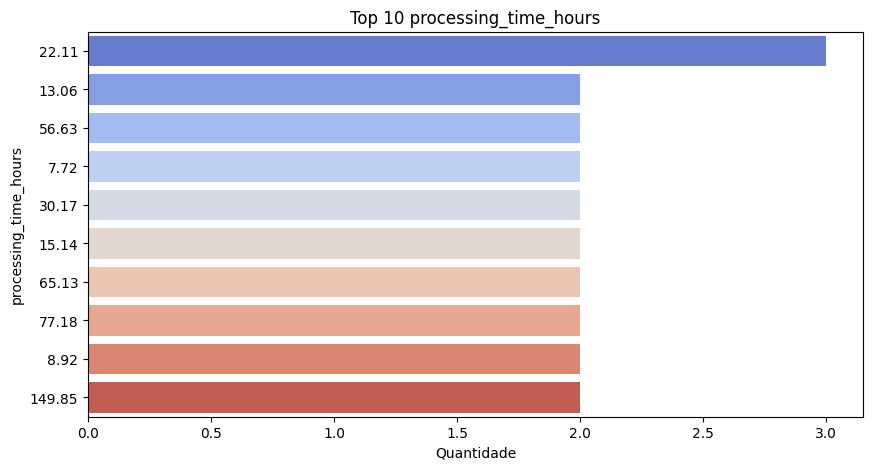

C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\945001677.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


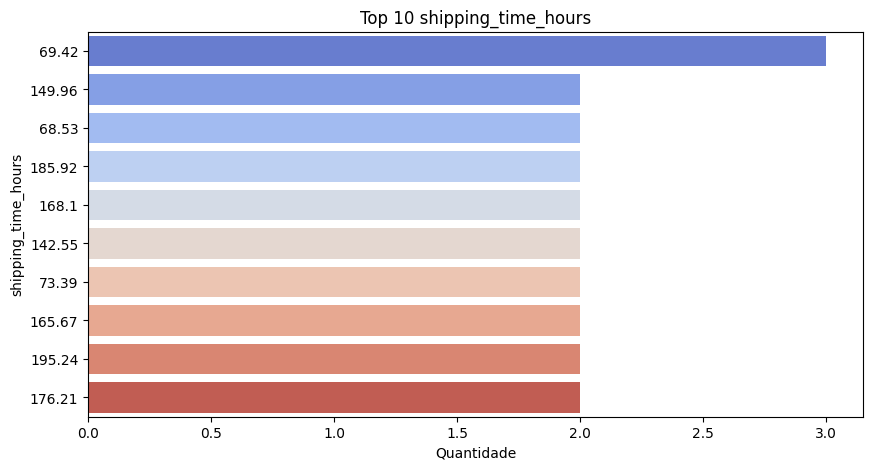

C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\945001677.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


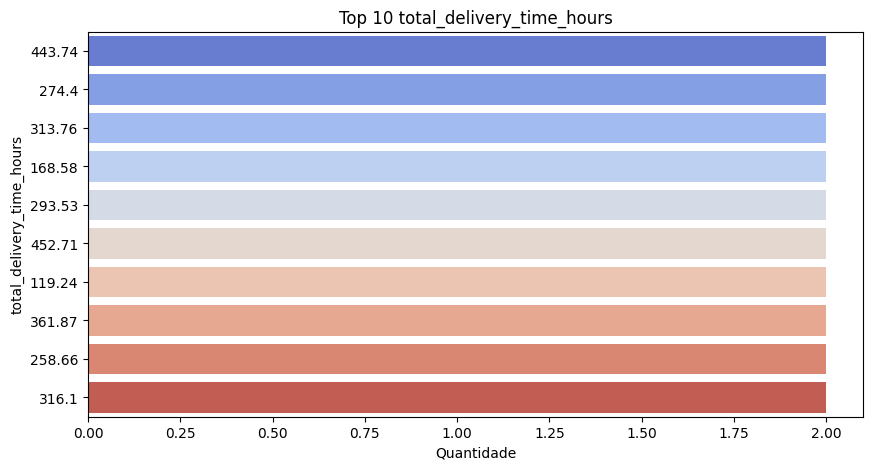

C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\945001677.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


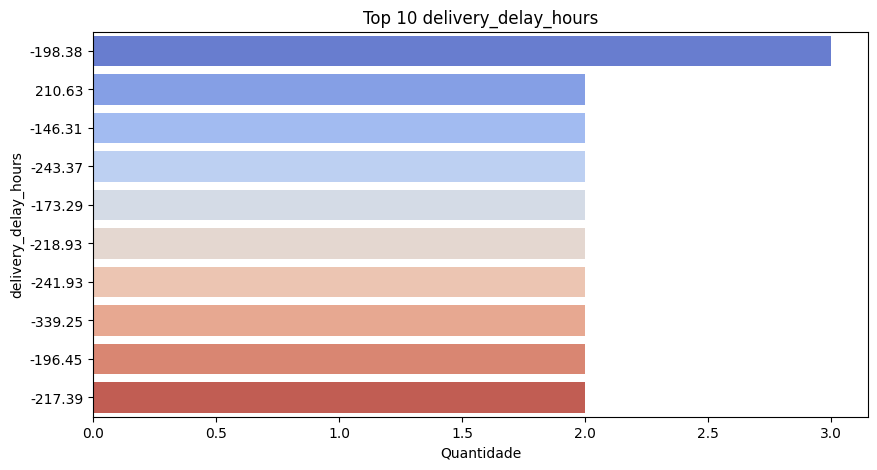

C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\945001677.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


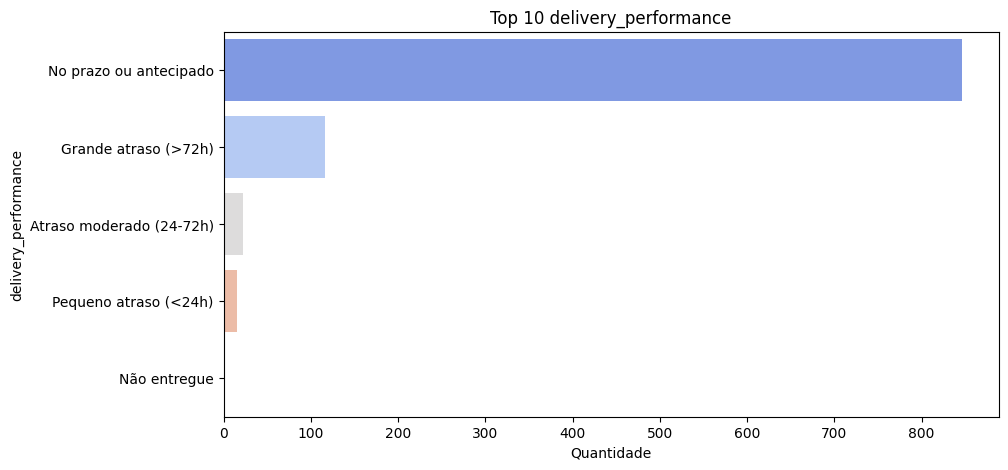

C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\945001677.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


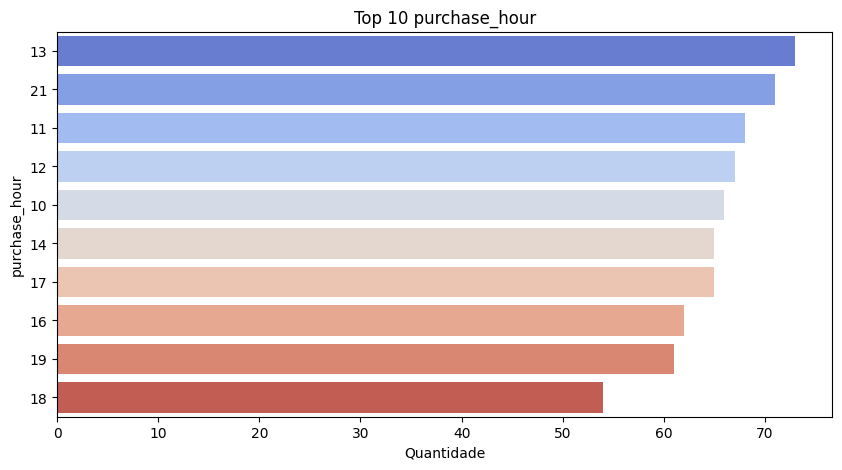

C:\Users\pacie\AppData\Local\Temp\ipykernel_4272\945001677.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


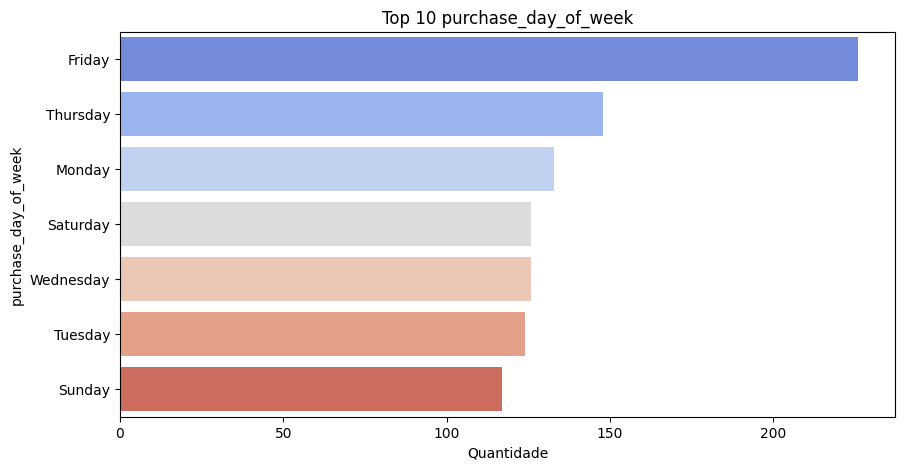

In [8]:
# numericas e categoricas

import matplotlib.pyplot as plt
import seaborn as sns

for col in cat_cols[-7:]:
    top_values = df_orders[col].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")
    plt.title(f"Top 10 {col}")
    plt.xlabel("Quantidade")
    plt.ylabel(col)
    plt.show()
